In [1]:
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

In [2]:
with open('CSV_Creation/OECD_countries_data.csv') as f:
    overall_data_by_country = pd.read_csv(f, error_bad_lines=False)

#we want to predict Death_rate by using countries' features 
features = list(overall_data_by_country.columns)
features.remove('Death_rate')
features.remove('Country')
overall_data_by_country = overall_data_by_country.set_index('Country')

#countries are classified according their death rate. Countries with the label 'True' means 
#that these countries have a high mortality rate compare to other countries

def classify_countries(threshold, overall_data_by_country):
    death_rate_class = []
    for i in range(overall_data_by_country.shape[0]):
        if overall_data_by_country.values[i,0] > threshold:
            death_rate_class.append(True)
        else:
            death_rate_class.append(False)
    return np.array(death_rate_class)

death_rate_class = classify_countries(8, overall_data_by_country) #the label (y)
other_data = overall_data_by_country[features].values #features to find the label (X)

In [3]:
#Random Forest and Decison Tree are compared for classifying the data
#Both calssifications are assessed through a cross validation
cv = StratifiedKFold(n_splits=5)
Rfc= RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=True)
Dtc = DecisionTreeClassifier(criterion='gini')
Adc = AdaBoostClassifier()
Gbc = GradientBoostingClassifier()


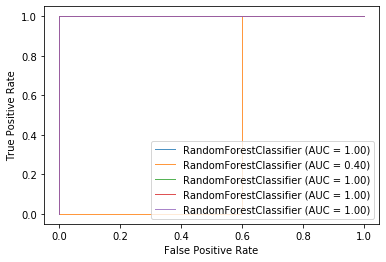

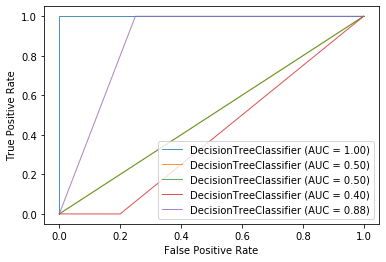

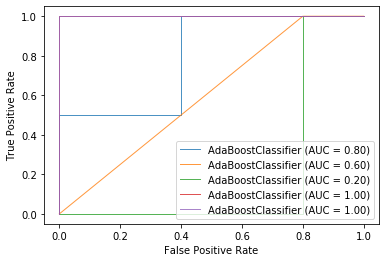

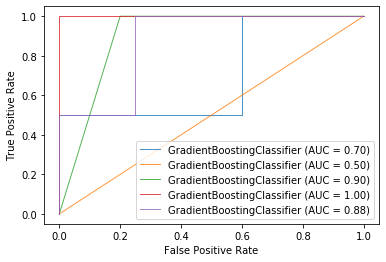

In [4]:
#this function returns the mean scores for ROC and AUC scores
def mean_fpr_tpr_auc(Method,X, y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        Method.fit(X[train],y[train])
        viz = plot_roc_curve(Method, X[test], y[test], alpha = 0.8, ax = ax, lw = 1)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    return (mean_fpr, mean_tpr, mean_auc, std_auc)

(mean_fpr_Rfc, mean_tpr_Rfc, mean_auc_Rfc, std_auc_Rfc) = mean_fpr_tpr_auc(Rfc, other_data, death_rate_class)
(mean_fpr_Dtc, mean_tpr_Dtc, mean_auc_Dtc, std_auc_Dtc) = mean_fpr_tpr_auc(Dtc, other_data, death_rate_class)
(mean_fpr_Adc, mean_tpr_Adc, mean_auc_Adc, std_auc_Adc) = mean_fpr_tpr_auc(Adc, other_data, death_rate_class)
(mean_fpr_Gbc, mean_tpr_Gbc, mean_auc_Gbc, std_auc_Gbc) = mean_fpr_tpr_auc(Gbc, other_data, death_rate_class)

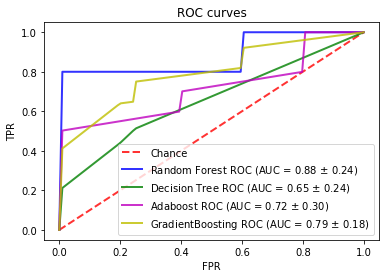

In [7]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.plot(mean_fpr_Rfc, mean_tpr_Rfc, color='b',
        label=r'Random Forest ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_Rfc, std_auc_Rfc),
        lw=2, alpha=.8)
ax.plot(mean_fpr_Dtc, mean_tpr_Dtc, color='g',
        label=r'Decision Tree ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_Dtc, std_auc_Dtc),
        lw=2, alpha=.8)
ax.plot(mean_fpr_Adc, mean_tpr_Adc, color='m',
        label=r'Adaboost ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_Adc, std_auc_Adc),
        lw=2, alpha=.8)
ax.plot(mean_fpr_Gbc, mean_tpr_Gbc, color='y',
        label=r'GradientBoosting ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_Gbc, std_auc_Gbc),
        lw=2, alpha=.8)

ax.set(xlim=[-0.05, 1.05], xlabel = 'FPR', ylim=[-0.05, 1.05], ylabel = 'TPR', title="ROC curves")
ax.legend(loc='lower right')

plt.show()